In [1]:
import glob
from pandas.core.common import flatten
import random
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import albumentations as A
import cv2
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
train_data_path = 'images'
train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]

print("Train size: {}\nValid size: {}".format(len(train_image_paths), len(valid_image_paths)))

train_image_path example:  images/plus_minus/263.png
class example:  minus_minus
Train size: 1200
Valid size: 300


In [13]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

#######################################################
#               Define Dataset Class
#######################################################

class HicDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

        self.transform = A.Compose(
    [
        #A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=21, width=21),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label

#######################################################
#                  Create Dataset
#######################################################


train_dataset = HicDataset(train_image_paths)
valid_dataset = HicDataset(valid_image_paths)

#######################################################
#                  Define Dataloaders
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)

In [14]:
def train_test(model, optimizer, n_epoch):
    model.train()
    train_loss = []
    train_accu = []
    i = 0
    test_losses = []
    for epoch in range(n_epoch):
        for data, target in train_loader:
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            print(output)
            print(target)
            loss = F.nll_loss(output, target)
            loss.backward()    # calc gradients
            train_loss.append(loss.data.item())
            optimizer.step()   # update gradients
            prediction = output.data.max(1)[1]   # first column has actual prob.
            for batch in train_loader:
                break
            batch_size =  batch[0].size()[0]
            accuracy = prediction.eq(target.data).sum()/batch_size*100
            train_accu.append(accuracy)
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.data.item(), accuracy))
            i += 1
            if i % 10 == 0:
                model.eval()
                test_loss = 0
                correct = 0
                for j in range(10):
                    with torch.no_grad():
                        for data, target in valid_loader:
                            output = model(data)
                            test_loss += F.nll_loss(output, target, size_average=False).item()
                            pred = output.data.max(1, keepdim=True)[1]
                            correct += pred.eq(target.data.view_as(pred)).sum()
                    test_loss /= len(valid_loader.dataset)
                    test_losses.append(test_loss)
                    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                    test_loss, correct, len(valid_loader.dataset),
                    10. * correct / len(valid_loader.dataset)))
                model.train()

                plt.plot(np.arange(len(train_loss)), train_loss, color='blue')
                plt.plot(np.arange(len(test_losses)), test_losses, color='red')
                plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
                plt.xlabel('number of training examples seen')
                plt.ylabel('negative log likelihood loss')
                plt.show()

In [15]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self._model = nn.Sequential(
            nn.Conv2d(1, 32, 2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 2),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 5)

    def _block(self, dim_in: int, dim_out: int, kernel_size: int = 5, padding: int = 2) -> nn.Module:
        return nn.Sequential(
           nn.Conv2d(dim_in, dim_out, kernel_size, padding=padding),
           nn.ReLU(),
           nn.MaxPool2d(3)
        )

    def forward(self, x):
        x = self._model(x)

        x = x.view(-1, 64)
        x = self.fc1(x)
        print(x.size())
        x = F.dropout(x, training=self.training, p = 0.5)
        print(x.size())
        x = self.fc2(x)
        print(x.size())
        return F.sigmoid(x)

model = MnistModel()
model

MnistModel(
  (_model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)

In [21]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        # число входных каналов равно единице, т.к картинка ч/б
        # число выходных каналов устанавливаем произвольно
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        # число входных каналов наследуется от предыдущего сверточного слоя. Число выходных каналов -- произвольно
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        # размер входного тензора после Flatten узнаем из тестового прогона ячейкой ниже. Размер выходного -- произвольно
        self.fc1 = nn.Linear(in_features=144, out_features=120)
        # размер входного налсдуется от предыдущего слоя. Выходного -- произвольно
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # размер входного налсдуется от предыдущего слоя. Выходного -- произвольно
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x =self.flatten(x) # превратили тензор в одномерный.
        #print(x.shape) # узнали размер выходного тензора после второго сверточного слоя
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

tensor([[0.0000, 0.0000, 0.0000, 0.0023, 0.0000, 0.0853, 0.0000, 0.0000, 0.0508,
         0.0707],
        [0.0000, 0.0000, 0.0000, 0.0122, 0.0000, 0.0821, 0.0000, 0.0000, 0.0512,
         0.0590],
        [0.0000, 0.0000, 0.0000, 0.0040, 0.0000, 0.1003, 0.0000, 0.0000, 0.0576,
         0.0593],
        [0.0000, 0.0000, 0.0000, 0.0060, 0.0000, 0.0849, 0.0000, 0.0000, 0.0529,
         0.0532],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0912, 0.0000, 0.0000, 0.0423,
         0.0996],
        [0.0000, 0.0000, 0.0000, 0.0063, 0.0000, 0.0842, 0.0000, 0.0000, 0.0455,
         0.0602],
        [0.0000, 0.0000, 0.0000, 0.0171, 0.0000, 0.0949, 0.0000, 0.0000, 0.0532,
         0.0687],
        [0.0000, 0.0000, 0.0000, 0.0123, 0.0000, 0.0861, 0.0000, 0.0000, 0.0490,
         0.0606],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0977, 0.0000, 0.0000, 0.0427,
         0.0893],
        [0.0000, 0.0000, 0.0000, 0.0098, 0.0000, 0.0921, 0.0000, 0.0000, 0.0520,
         0.0646],
        [0

/home/vit/miniconda3/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: -0.0121, Accuracy: 0/300 (0%)


Test set: Avg. loss: -0.0121, Accuracy: 0/300 (0%)


Test set: Avg. loss: -0.0121, Accuracy: 0/300 (0%)


Test set: Avg. loss: -0.0121, Accuracy: 0/300 (0%)


Test set: Avg. loss: -0.0121, Accuracy: 0/300 (0%)


Test set: Avg. loss: -0.0121, Accuracy: 0/300 (0%)


Test set: Avg. loss: -0.0121, Accuracy: 0/300 (0%)


Test set: Avg. loss: -0.0121, Accuracy: 0/300 (0%)


Test set: Avg. loss: -0.0121, Accuracy: 0/300 (0%)


Test set: Avg. loss: -0.0121, Accuracy: 0/300 (0%)



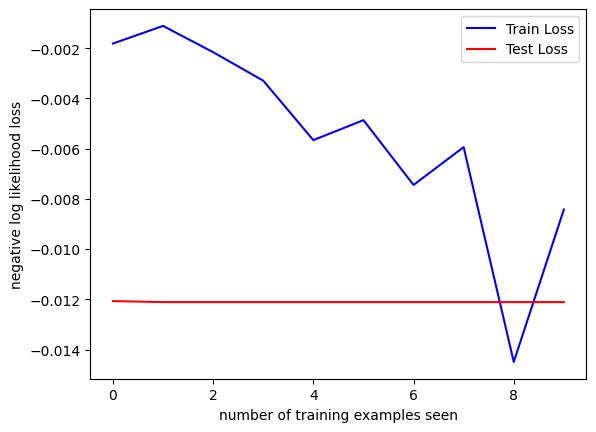

tensor([[0.0000, 0.0000, 0.0000, 0.0574, 0.0000, 0.0983, 0.0000, 0.0000, 0.0567,
         0.0591],
        [0.0000, 0.0000, 0.0000, 0.0562, 0.0000, 0.0982, 0.0000, 0.0000, 0.0476,
         0.0652],
        [0.0000, 0.0000, 0.0000, 0.0505, 0.0000, 0.0949, 0.0000, 0.0000, 0.0451,
         0.0939],
        [0.0000, 0.0000, 0.0000, 0.0648, 0.0000, 0.0948, 0.0000, 0.0000, 0.0494,
         0.0634],
        [0.0000, 0.0000, 0.0000, 0.0642, 0.0000, 0.0940, 0.0000, 0.0000, 0.0428,
         0.0590],
        [0.0000, 0.0000, 0.0000, 0.0535, 0.0000, 0.0874, 0.0000, 0.0000, 0.0504,
         0.0697],
        [0.0000, 0.0000, 0.0000, 0.0550, 0.0000, 0.0984, 0.0000, 0.0000, 0.0555,
         0.0571],
        [0.0000, 0.0000, 0.0000, 0.0506, 0.0000, 0.0823, 0.0000, 0.0000, 0.0367,
         0.1028],
        [0.0000, 0.0000, 0.0000, 0.0537, 0.0000, 0.0994, 0.0000, 0.0000, 0.0526,
         0.0621],
        [0.0000, 0.0000, 0.0000, 0.0641, 0.0000, 0.0900, 0.0000, 0.0000, 0.0533,
         0.0785],
        [0

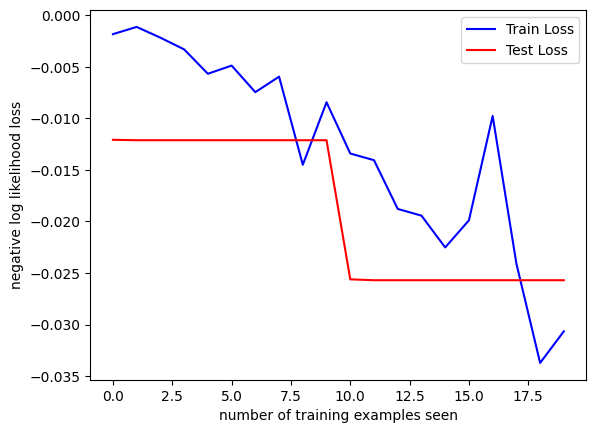

tensor([[0.0000, 0.0000, 0.0000, 0.1327, 0.0000, 0.0869, 0.0000, 0.0000, 0.0450,
         0.0592],
        [0.0000, 0.0000, 0.0000, 0.1275, 0.0000, 0.0877, 0.0000, 0.0000, 0.0409,
         0.0591],
        [0.0000, 0.0000, 0.0000, 0.1155, 0.0000, 0.1002, 0.0000, 0.0000, 0.0468,
         0.0867],
        [0.0000, 0.0000, 0.0000, 0.1097, 0.0000, 0.0889, 0.0000, 0.0000, 0.0383,
         0.1027],
        [0.0000, 0.0000, 0.0000, 0.1104, 0.0000, 0.0860, 0.0000, 0.0000, 0.0369,
         0.1080],
        [0.0000, 0.0000, 0.0000, 0.1267, 0.0000, 0.0976, 0.0000, 0.0000, 0.0503,
         0.0680],
        [0.0000, 0.0000, 0.0000, 0.1222, 0.0000, 0.0963, 0.0000, 0.0000, 0.0435,
         0.0592],
        [0.0000, 0.0000, 0.0000, 0.1070, 0.0000, 0.0888, 0.0000, 0.0000, 0.0369,
         0.0954],
        [0.0000, 0.0000, 0.0000, 0.1274, 0.0000, 0.0936, 0.0000, 0.0000, 0.0496,
         0.0740],
        [0.0000, 0.0000, 0.0000, 0.1230, 0.0000, 0.0911, 0.0000, 0.0000, 0.0436,
         0.0738],
        [0

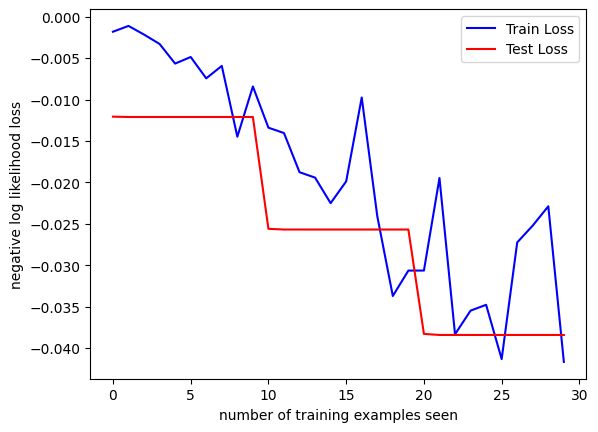

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7747e-01, 0.0000e+00, 8.5206e-02,
         0.0000e+00, 0.0000e+00, 4.6188e-02, 6.9722e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7081e-01, 0.0000e+00, 8.7772e-02,
         0.0000e+00, 0.0000e+00, 4.9655e-02, 4.9257e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7459e-01, 0.0000e+00, 7.8390e-02,
         0.0000e+00, 0.0000e+00, 4.8992e-02, 6.3103e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8065e-01, 0.0000e+00, 9.4798e-02,
         0.0000e+00, 0.0000e+00, 5.0250e-02, 7.3705e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9222e-01, 0.0000e+00, 8.2438e-02,
         0.0000e+00, 0.0000e+00, 4.0415e-02, 6.5718e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7770e-01, 0.0000e+00, 8.6580e-02,
         0.0000e+00, 0.0000e+00, 4.1878e-02, 5.2466e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7097e-01, 0.0000e+00, 9.3523e-02,
         0.0000e+00, 0.0000e+00, 3.7704e-02, 1.0125e-01],
        [0.0000e+00, 0.0000

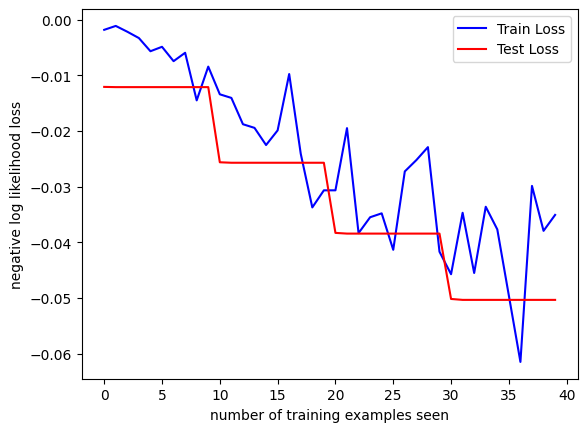

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4593e-01, 0.0000e+00, 9.9028e-02,
         0.0000e+00, 0.0000e+00, 4.1292e-02, 6.6617e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5724e-01, 0.0000e+00, 8.5610e-02,
         0.0000e+00, 0.0000e+00, 3.8380e-02, 5.8399e-02],
        [0.0000e+00, 0.0000e+00, 4.1102e-03, 2.3862e-01, 0.0000e+00, 1.0103e-01,
         0.0000e+00, 0.0000e+00, 5.1331e-02, 4.9534e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5678e-01, 0.0000e+00, 8.5401e-02,
         0.0000e+00, 0.0000e+00, 3.1000e-02, 5.4402e-02],
        [0.0000e+00, 0.0000e+00, 1.8744e-03, 2.3988e-01, 0.0000e+00, 1.0350e-01,
         0.0000e+00, 0.0000e+00, 4.3591e-02, 5.3361e-02],
        [0.0000e+00, 0.0000e+00, 4.3678e-04, 2.3903e-01, 0.0000e+00, 9.5269e-02,
         0.0000e+00, 0.0000e+00, 4.4542e-02, 5.4360e-02],
        [0.0000e+00, 0.0000e+00, 1.2270e-04, 2.4764e-01, 0.0000e+00, 9.5133e-02,
         0.0000e+00, 0.0000e+00, 4.3064e-02, 7.6102e-02],
        [0.0000e+00, 0.0000

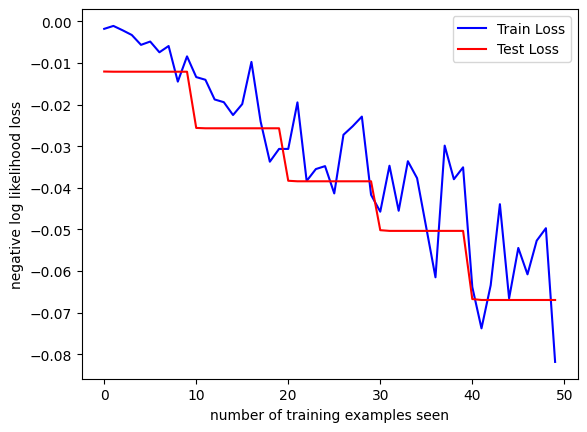

tensor([[0.0000, 0.0000, 0.0210, 0.2976, 0.0000, 0.1017, 0.0000, 0.0000, 0.0474,
         0.0541],
        [0.0000, 0.0000, 0.0186, 0.2957, 0.0000, 0.1001, 0.0000, 0.0000, 0.0387,
         0.0494],
        [0.0000, 0.0000, 0.0200, 0.2919, 0.0000, 0.0990, 0.0000, 0.0000, 0.0378,
         0.1010],
        [0.0000, 0.0000, 0.0192, 0.3058, 0.0000, 0.1017, 0.0000, 0.0000, 0.0406,
         0.0704],
        [0.0000, 0.0000, 0.0284, 0.3107, 0.0000, 0.0996, 0.0000, 0.0000, 0.0262,
         0.0593],
        [0.0000, 0.0000, 0.0220, 0.3076, 0.0000, 0.0983, 0.0000, 0.0000, 0.0344,
         0.0794],
        [0.0000, 0.0000, 0.0142, 0.3026, 0.0000, 0.0905, 0.0000, 0.0000, 0.0322,
         0.0899],
        [0.0000, 0.0000, 0.0118, 0.3282, 0.0000, 0.0869, 0.0000, 0.0000, 0.0299,
         0.0536],
        [0.0000, 0.0000, 0.0170, 0.2976, 0.0000, 0.0969, 0.0000, 0.0000, 0.0390,
         0.0539],
        [0.0000, 0.0000, 0.0258, 0.2859, 0.0000, 0.0926, 0.0000, 0.0000, 0.0273,
         0.1075],
        [0

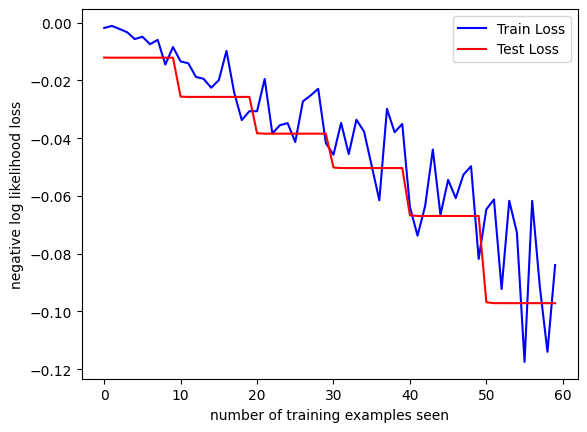

tensor([[0.0000, 0.0000, 0.0922, 0.3708, 0.0000, 0.1044, 0.0000, 0.0000, 0.0280,
         0.0543],
        [0.0000, 0.0000, 0.0919, 0.3762, 0.0000, 0.1006, 0.0000, 0.0000, 0.0219,
         0.0809],
        [0.0000, 0.0000, 0.0869, 0.4019, 0.0000, 0.0891, 0.0000, 0.0000, 0.0158,
         0.0563],
        [0.0000, 0.0000, 0.0869, 0.3688, 0.0000, 0.1026, 0.0000, 0.0000, 0.0329,
         0.0541],
        [0.0000, 0.0000, 0.0909, 0.3746, 0.0000, 0.1046, 0.0000, 0.0000, 0.0212,
         0.0861],
        [0.0000, 0.0000, 0.0919, 0.3783, 0.0000, 0.0968, 0.0000, 0.0000, 0.0192,
         0.0973],
        [0.0000, 0.0000, 0.0962, 0.3791, 0.0000, 0.0952, 0.0000, 0.0000, 0.0237,
         0.0504],
        [0.0000, 0.0000, 0.0875, 0.3600, 0.0000, 0.1048, 0.0000, 0.0000, 0.0289,
         0.0563],
        [0.0000, 0.0000, 0.1035, 0.3966, 0.0000, 0.0964, 0.0000, 0.0000, 0.0213,
         0.0461],
        [0.0000, 0.0000, 0.0870, 0.3705, 0.0000, 0.1025, 0.0000, 0.0000, 0.0245,
         0.0514],
        [0

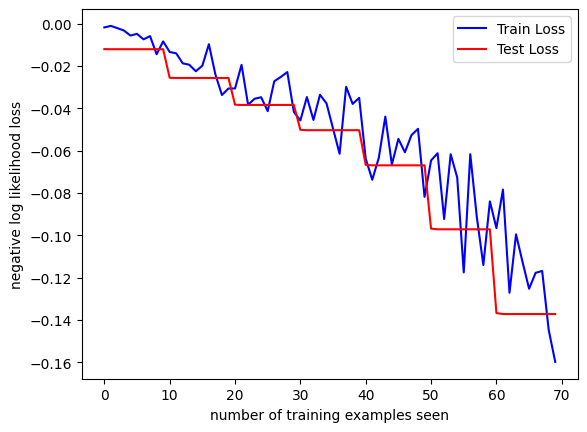

tensor([[0.0000, 0.0000, 0.1699, 0.4726, 0.0038, 0.0979, 0.0000, 0.0000, 0.0000,
         0.0602],
        [0.0000, 0.0000, 0.1701, 0.4262, 0.0331, 0.0911, 0.0000, 0.0000, 0.0029,
         0.1218],
        [0.0000, 0.0000, 0.1742, 0.4770, 0.0065, 0.1038, 0.0000, 0.0000, 0.0000,
         0.0605],
        [0.0000, 0.0000, 0.1715, 0.4536, 0.0166, 0.0993, 0.0000, 0.0000, 0.0007,
         0.0885],
        [0.0000, 0.0000, 0.1713, 0.4788, 0.0111, 0.0973, 0.0000, 0.0000, 0.0000,
         0.0637],
        [0.0000, 0.0000, 0.1788, 0.4386, 0.0111, 0.1125, 0.0000, 0.0000, 0.0232,
         0.0693],
        [0.0000, 0.0000, 0.1636, 0.4385, 0.0006, 0.1061, 0.0000, 0.0000, 0.0207,
         0.0566],
        [0.0000, 0.0000, 0.1728, 0.4536, 0.0092, 0.0987, 0.0000, 0.0000, 0.0066,
         0.0649],
        [0.0000, 0.0000, 0.1686, 0.4490, 0.0107, 0.1082, 0.0000, 0.0000, 0.0093,
         0.0862],
        [0.0000, 0.0000, 0.1620, 0.4374, 0.0000, 0.1056, 0.0000, 0.0000, 0.0189,
         0.0630],
        [0

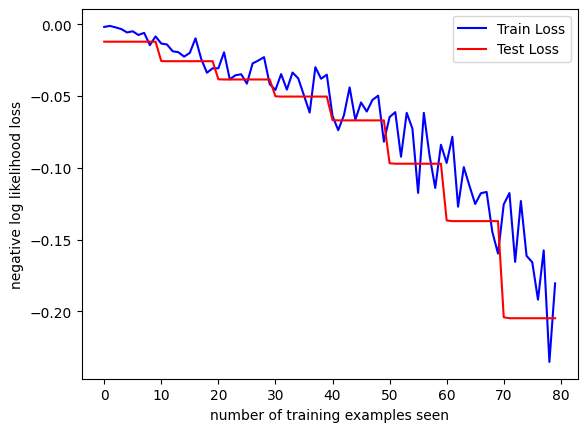

tensor([[0.0000, 0.0000, 0.2913, 0.5645, 0.1204, 0.0949, 0.0000, 0.0000, 0.0000,
         0.1064],
        [0.0000, 0.0000, 0.2826, 0.5287, 0.1356, 0.0995, 0.0000, 0.0000, 0.0000,
         0.1380],
        [0.0000, 0.0000, 0.2554, 0.5263, 0.0748, 0.1159, 0.0000, 0.0000, 0.0018,
         0.0633],
        [0.0000, 0.0000, 0.2758, 0.5786, 0.0985, 0.0948, 0.0000, 0.0000, 0.0000,
         0.0724],
        [0.0000, 0.0000, 0.2556, 0.5187, 0.1265, 0.0935, 0.0000, 0.0000, 0.0000,
         0.1404],
        [0.0000, 0.0000, 0.2991, 0.5702, 0.1183, 0.1012, 0.0000, 0.0000, 0.0000,
         0.0645],
        [0.0000, 0.0000, 0.2604, 0.5353, 0.0857, 0.1152, 0.0000, 0.0000, 0.0000,
         0.0620],
        [0.0000, 0.0000, 0.3192, 0.5726, 0.1436, 0.0956, 0.0000, 0.0000, 0.0000,
         0.0902],
        [0.0000, 0.0000, 0.2664, 0.5291, 0.1461, 0.0828, 0.0000, 0.0000, 0.0000,
         0.1541],
        [0.0000, 0.0000, 0.2780, 0.5501, 0.1152, 0.1077, 0.0000, 0.0000, 0.0000,
         0.1095],
        [0

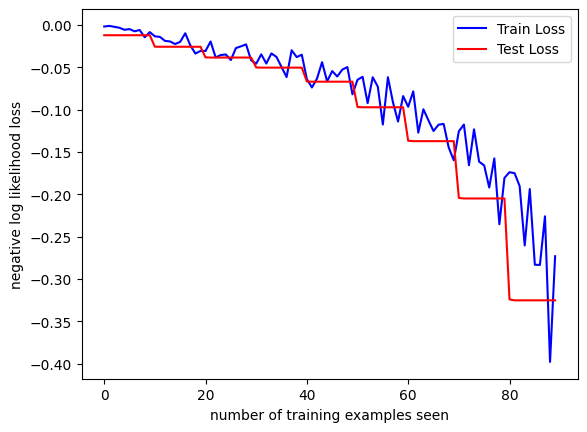

tensor([[0.0000, 0.0000, 0.4856, 0.7577, 0.2591, 0.0974, 0.0000, 0.0000, 0.0000,
         0.0916],
        [0.0000, 0.0000, 0.4683, 0.7049, 0.2672, 0.1052, 0.0000, 0.0000, 0.0000,
         0.1219],
        [0.0000, 0.0000, 0.5521, 0.7362, 0.3077, 0.1034, 0.0000, 0.0000, 0.0000,
         0.1170],
        [0.0000, 0.0000, 0.4870, 0.7577, 0.2670, 0.0921, 0.0000, 0.0000, 0.0000,
         0.0991],
        [0.0000, 0.0000, 0.4561, 0.6783, 0.3029, 0.1023, 0.0000, 0.0000, 0.0000,
         0.1546],
        [0.0000, 0.0000, 0.4821, 0.7602, 0.2634, 0.0905, 0.0000, 0.0000, 0.0000,
         0.0976],
        [0.0000, 0.0000, 0.4346, 0.6849, 0.2311, 0.1134, 0.0000, 0.0000, 0.0000,
         0.0782],
        [0.0000, 0.0000, 0.4365, 0.6786, 0.2212, 0.1167, 0.0000, 0.0000, 0.0000,
         0.0762],
        [0.0000, 0.0000, 0.4747, 0.7451, 0.2548, 0.0962, 0.0000, 0.0000, 0.0000,
         0.0964],
        [0.0000, 0.0000, 0.4909, 0.7702, 0.2690, 0.0922, 0.0000, 0.0000, 0.0000,
         0.0981],
        [0

In [22]:
model = LeNet()

learning_rate = 0.01
momentum = 0.5


optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

train_test(model, optimizer, 5)